# Focused Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the Focused data set. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Focused Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is woth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. The Focused dataset consists on the compilation of all data points that characterize as constraints. Since the objective of this transformation is to study the effect of a more focused dataset on the model performance, after training, the model performance is evaluated on the previous sparse data set. 

In [1]:
import sys; sys.path.append('..')
from thesis_package import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

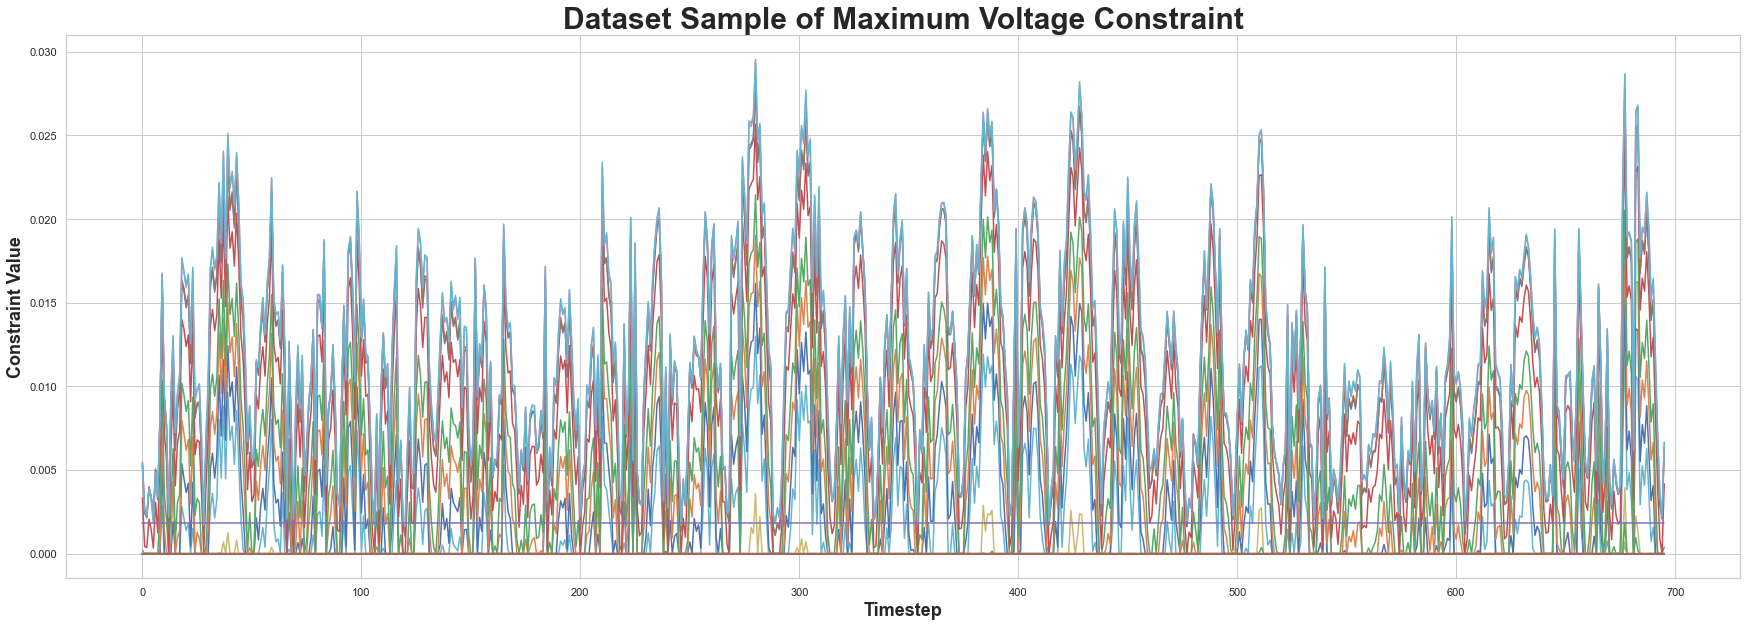

In [2]:
y_max_u_focused = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
exogenous_data_vm_pu_max_focused = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data_vm_pu_max_focused, y_max_u_focused)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

## Import Libraries

In [3]:
import optuna 
import os

import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils, metrics

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [4]:
# General parameters
num_trials = 30

In [5]:
# Regression
y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
train_x, valid_x, train_y, valid_y, scaler_max = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
data_max_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler_min = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
data_min_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
# Threshold
threshold_max = utils.compute_threshold(y_max_u) / scaler_max['y']
threshold_min = utils.compute_threshold(y_min_u) / scaler_min['y']
print(threshold_min)
print(threshold_max)
# Classification
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
data_max_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
data_min_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

0.0644069763149719
0.05260425830867303


### Extreme Gradient Boosting Regressor

In [6]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 18:38:33,518] A new study created in memory with name: no-name-1f58e543-c38d-4fc2-badb-80b7b5e3055f
[I 2022-10-14 18:41:21,631] Trial 0 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.005224560143410642, 'alpha': 2.0628311706645826e-06, 'subsample': 0.7893099140136017, 'colsample_bytree': 0.613420740727956, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.0008160326482940956, 'gamma': 0.3245034452446554, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.08580029072201e-05, 'skip_drop': 0.01008837542419756}. Best is trial 0 with value: -1.0.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:42:13,043] Trial 1 finished with value: 0.15585246005568038 and parameters: {'booster': 'gblinear', 'lambda': 2.3662523840022772e-08, 'alpha': 8.089856285368484e-08, 'subsample': 0.9092514467483583, 'colsample_bytree': 0.9639878467778702}. Best is trial 1 with value: 0.15585246005568038.


true_positives_ctr:  4665
true_negatives_ctr:  222613
false_positives_ctr:  79934
false_negatives_ctr:  284
28234477650155335209


[I 2022-10-14 18:43:06,947] Trial 2 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.00021720122607235724, 'alpha': 0.19176969219472703, 'subsample': 0.6164202200556408, 'colsample_bytree': 0.4554469921256068, 'max_depth': 3, 'min_child_weight': 9, 'eta': 4.265080738017451e-07, 'gamma': 2.9853393437171307e-05, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.15585246005568038.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:44:03,295] Trial 3 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.19116744398823723, 'alpha': 2.0769338141831727e-08, 'subsample': 0.3427115001200315, 'colsample_bytree': 0.5440754320686458, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.0003773629090560179, 'gamma': 0.0058827084502495065, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.15585246005568038.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:45:22,888] Trial 4 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.00037920974359778776, 'alpha': 1.5061262474873477e-06, 'subsample': 0.6034848737325114, 'colsample_bytree': 0.6306520608916604, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.015444706978059813, 'gamma': 0.026645075995807944, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.15585246005568038.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:47:48,752] Trial 5 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.046076323417961286, 'alpha': 0.04532136943567738, 'subsample': 0.3231705770682769, 'colsample_bytree': 0.4698275092589403, 'max_depth': 7, 'min_child_weight': 7, 'eta': 3.561309444107094e-05, 'gamma': 0.020384763164422042, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.003975787949959626, 'skip_drop': 5.92187838639345e-07}. Best is trial 1 with value: 0.15585246005568038.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:48:57,083] Trial 6 finished with value: 0.193961237021476 and parameters: {'booster': 'gbtree', 'lambda': 1.639655679491451e-05, 'alpha': 0.3223750554005607, 'subsample': 0.668014898279301, 'colsample_bytree': 0.882980965621005, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.04012561455812096, 'gamma': 0.00016557051366229347, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.193961237021476.


true_positives_ctr:  4208
true_negatives_ctr:  260058
false_positives_ctr:  42489
false_negatives_ctr:  741
18234976468105098009


[I 2022-10-14 18:52:15,390] Trial 7 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 2.0993854083553427e-05, 'alpha': 3.23214502432125e-08, 'subsample': 0.7829308628364593, 'colsample_bytree': 0.9148814147676232, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.004178377761788748, 'gamma': 0.0040155373850712895, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.04060007176548081, 'skip_drop': 0.013011678037498238}. Best is trial 6 with value: 0.193961237021476.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:54:35,580] Trial 8 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.037918522313940294, 'alpha': 0.5689161791440662, 'subsample': 0.7885394205714642, 'colsample_bytree': 0.3634518665653941, 'max_depth': 7, 'min_child_weight': 8, 'eta': 1.168178982718858e-06, 'gamma': 4.955433493039273e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.190594617314132e-05, 'skip_drop': 0.019352797005285548}. Best is trial 6 with value: 0.193961237021476.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 18:56:36,655] Trial 9 finished with value: 0.19891776053605428 and parameters: {'booster': 'dart', 'lambda': 6.89043785644038e-06, 'alpha': 0.014058949882463654, 'subsample': 0.2915004837908435, 'colsample_bytree': 0.9201359136327754, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.07808606657675021, 'gamma': 0.20514958619918894, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.822393909830603e-06, 'skip_drop': 0.511511207142775}. Best is trial 9 with value: 0.19891776053605428.


true_positives_ctr:  4187
true_negatives_ctr:  261684
false_positives_ctr:  40863
false_negatives_ctr:  762
17702926164540306900


[I 2022-10-14 18:57:47,888] Trial 10 finished with value: 0.14738150752812407 and parameters: {'booster': 'gblinear', 'lambda': 2.3721276423095149e-07, 'alpha': 0.0009762103497801377, 'subsample': 0.20998785670109757, 'colsample_bytree': 0.21851909518697699}. Best is trial 9 with value: 0.19891776053605428.


true_positives_ctr:  4652
true_negatives_ctr:  218353
false_positives_ctr:  84194
false_negatives_ctr:  297
29086915301455823700


[I 2022-10-14 18:58:51,617] Trial 11 finished with value: 0.23605123728877164 and parameters: {'booster': 'gbtree', 'lambda': 4.657815392650245e-06, 'alpha': 0.0036002046432531366, 'subsample': 0.4499861453689844, 'colsample_bytree': 0.8126176995692562, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.5369253811580071, 'gamma': 9.857758967308361e-05, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.23605123728877164.


true_positives_ctr:  3345
true_negatives_ctr:  286160
false_positives_ctr:  16387
false_negatives_ctr:  1604
8501936817677042544


[I 2022-10-14 19:01:45,342] Trial 12 finished with value: 0.17757226918578772 and parameters: {'booster': 'dart', 'lambda': 9.780796875201575e-07, 'alpha': 0.004758507442099754, 'subsample': 0.4443282341574177, 'colsample_bytree': 0.7781378045804042, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.832847831734253, 'gamma': 1.1832480913650814e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.8853388933786973e-08, 'skip_drop': 0.9759444378656263}. Best is trial 11 with value: 0.23605123728877164.


true_positives_ctr:  3221
true_negatives_ctr:  279012
false_positives_ctr:  23535
false_negatives_ctr:  1728
11246976496591582320


[I 2022-10-14 19:02:49,440] Trial 13 finished with value: 0.10062900022944574 and parameters: {'booster': 'gbtree', 'lambda': 2.001159445497006e-06, 'alpha': 0.00011895125195504889, 'subsample': 0.4612576949423469, 'colsample_bytree': 0.7669925719814725, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.9388492401285071, 'gamma': 1.2066518107105741e-08, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.23605123728877164.


true_positives_ctr:  2771
true_negatives_ctr:  271374
false_positives_ctr:  31173
false_negatives_ctr:  2178
13903150303109096064


[I 2022-10-14 19:03:38,780] Trial 14 finished with value: 0.16983062158231346 and parameters: {'booster': 'gblinear', 'lambda': 1.963662451914869e-08, 'alpha': 0.006973321354290328, 'subsample': 0.4567792050594318, 'colsample_bytree': 0.7918127310675417}. Best is trial 11 with value: 0.23605123728877164.


true_positives_ctr:  4726
true_negatives_ctr:  234921
false_positives_ctr:  67626
false_negatives_ctr:  223
25473859375589124864


[I 2022-10-14 19:06:07,495] Trial 15 finished with value: 0.1749431478006645 and parameters: {'booster': 'dart', 'lambda': 1.2098530338761938e-05, 'alpha': 6.200882584499884e-05, 'subsample': 0.24532848181416353, 'colsample_bytree': 0.9948169203453324, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.07457190729428002, 'gamma': 0.8818334062924899, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.51731974248243e-07, 'skip_drop': 3.4662631513057967e-06}. Best is trial 11 with value: 0.23605123728877164.


true_positives_ctr:  4726
true_negatives_ctr:  234921
false_positives_ctr:  67626
false_negatives_ctr:  223
25473859375589124864


[I 2022-10-14 19:07:03,505] Trial 16 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.002323115932595119, 'alpha': 0.00033010939843077175, 'subsample': 0.3510763811712053, 'colsample_bytree': 0.70160591023257, 'max_depth': 3, 'min_child_weight': 4, 'eta': 1.6441165784727283e-05, 'gamma': 0.00029520851758631873, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.23605123728877164.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:08:06,103] Trial 17 finished with value: 0.22565373576426684 and parameters: {'booster': 'gbtree', 'lambda': 7.311935013083716e-07, 'alpha': 0.01799605789986255, 'subsample': 0.5465324235049799, 'colsample_bytree': 0.859560061492714, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.15775481924055765, 'gamma': 2.9531110249902106e-06, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.23605123728877164.


true_positives_ctr:  3742
true_negatives_ctr:  278552
false_positives_ctr:  23995
false_negatives_ctr:  1207
11618601548589379449


[I 2022-10-14 19:09:04,867] Trial 18 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 1.8780338082210512e-07, 'alpha': 0.0012641025437257365, 'subsample': 0.5345873572482743, 'colsample_bytree': 0.8470836042155938, 'max_depth': 3, 'min_child_weight': 3, 'eta': 1.0586516849148136e-08, 'gamma': 1.0785229430352383e-06, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.23605123728877164.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:10:08,651] Trial 19 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 1.9552371668537322e-07, 'alpha': 2.21558293391146e-05, 'subsample': 0.6949739060120843, 'colsample_bytree': 0.7052936101113607, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.004025691558658469, 'gamma': 1.35890806471319e-06, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.23605123728877164.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:11:07,747] Trial 20 finished with value: 0.3372403148872632 and parameters: {'booster': 'gbtree', 'lambda': 0.00011351437848394804, 'alpha': 0.08734290813473895, 'subsample': 0.5337737548598787, 'colsample_bytree': 0.7052911514095703, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.17653328373032073, 'gamma': 4.4669316708593653e-08, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.3372403148872632.


true_positives_ctr:  3660
true_negatives_ctr:  292323
false_positives_ctr:  10224
false_negatives_ctr:  1289
6103777740103867824


[I 2022-10-14 19:12:06,099] Trial 21 finished with value: 0.304108235637553 and parameters: {'booster': 'gbtree', 'lambda': 8.925615802376532e-05, 'alpha': 0.036198076434216284, 'subsample': 0.5017788793585782, 'colsample_bytree': 0.709279323460736, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.21147438348090228, 'gamma': 1.0964467667945348e-08, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.3372403148872632.


true_positives_ctr:  3620
true_negatives_ctr:  290209
false_positives_ctr:  12338
false_negatives_ctr:  1329
6966007465819650612


[I 2022-10-14 19:13:03,092] Trial 22 finished with value: 0.14220358492024945 and parameters: {'booster': 'gbtree', 'lambda': 0.0010114146121851532, 'alpha': 0.08236541573714233, 'subsample': 0.43023254535673183, 'colsample_bytree': 0.6879396114282283, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.991209585086674, 'gamma': 2.744755428095187e-08, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.3372403148872632.


true_positives_ctr:  3008
true_negatives_ctr:  275978
false_positives_ctr:  26569
false_negatives_ctr:  1941
12307863313502272089


[I 2022-10-14 19:13:58,930] Trial 23 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.00016891777158832325, 'alpha': 0.002308955241590739, 'subsample': 0.5486633882872964, 'colsample_bytree': 0.5590950484542285, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.008640530216814213, 'gamma': 9.170291010666326e-08, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.3372403148872632.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:14:55,392] Trial 24 finished with value: 0.30712140636400576 and parameters: {'booster': 'gbtree', 'lambda': 5.1487340212568366e-05, 'alpha': 0.07969394813800806, 'subsample': 0.3849675563330821, 'colsample_bytree': 0.7425546735702615, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.1611686704904087, 'gamma': 1.1104940088075824e-07, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.3372403148872632.


true_positives_ctr:  3694
true_negatives_ctr:  289730
false_positives_ctr:  12817
false_negatives_ctr:  1255
7193732495620868505


[I 2022-10-14 19:15:51,640] Trial 25 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 4.8880866870751044e-05, 'alpha': 0.8935175942261415, 'subsample': 0.40200140295912035, 'colsample_bytree': 0.6783955719225696, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.0007396974068758632, 'gamma': 1.5887679948187092e-07, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.3372403148872632.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:16:42,766] Trial 26 finished with value: 0.1691341965931554 and parameters: {'booster': 'gblinear', 'lambda': 5.2452576069070246e-05, 'alpha': 0.057375223544218715, 'subsample': 0.3790037157234887, 'colsample_bytree': 0.7375738796034439}. Best is trial 20 with value: 0.3372403148872632.


true_positives_ctr:  4726
true_negatives_ctr:  234921
false_positives_ctr:  67626
false_negatives_ctr:  223
25473859375589124864


[I 2022-10-14 19:17:46,303] Trial 27 finished with value: 0.21879510885809156 and parameters: {'booster': 'gbtree', 'lambda': 0.005287651369991506, 'alpha': 0.1484716603745566, 'subsample': 0.5187805558269376, 'colsample_bytree': 0.6379617301225794, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.13510394742056098, 'gamma': 6.66404701363149e-08, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.3372403148872632.


true_positives_ctr:  3851
true_negatives_ctr:  275194
false_positives_ctr:  27353
false_negatives_ctr:  1098
12908889525050043504


[I 2022-10-14 19:18:45,190] Trial 28 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.0007052435956529896, 'alpha': 0.039854246197800126, 'subsample': 0.507790033599046, 'colsample_bytree': 0.5435335232478656, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.01718750358644562, 'gamma': 1.0244817331020338e-08, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.3372403148872632.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 19:19:44,801] Trial 29 finished with value: 0.34860523466710575 and parameters: {'booster': 'gbtree', 'lambda': 0.004325401285436115, 'alpha': 2.886626217683652e-06, 'subsample': 0.9730981237856324, 'colsample_bytree': 0.6063785521501784, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.23608766400626907, 'gamma': 2.6711567794982343e-07, 'grow_policy': 'depthwise'}. Best is trial 29 with value: 0.34860523466710575.


true_positives_ctr:  3481
true_negatives_ctr:  294392
false_positives_ctr:  8155
false_negatives_ctr:  1468
5154662914933376880
Number of finished trials:  30
Best trial:
  Value: 0.34860523466710575
  Params: 
    booster: gbtree
    lambda: 0.004325401285436115
    alpha: 2.886626217683652e-06
    subsample: 0.9730981237856324
    colsample_bytree: 0.6063785521501784
    max_depth: 3
    min_child_weight: 6
    eta: 0.23608766400626907
    gamma: 2.6711567794982343e-07
    grow_policy: depthwise


In [7]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 19:19:44,933] A new study created in memory with name: no-name-cbc1a3c3-55fc-47a0-a7b8-64c2baaed627
[I 2022-10-14 19:20:37,058] Trial 0 finished with value: 0.20986372279757254 and parameters: {'booster': 'gblinear', 'lambda': 8.534207580580718e-07, 'alpha': 0.2574178932797561, 'subsample': 0.7910447892520296, 'colsample_bytree': 0.6373747575081279}. Best is trial 0 with value: 0.20986372279757254.


true_positives_ctr:  5300
true_negatives_ctr:  252510
false_positives_ctr:  48964
false_negatives_ctr:  722
24947153743905222144


[I 2022-10-14 19:21:28,199] Trial 1 finished with value: 0.20986372279757254 and parameters: {'booster': 'gblinear', 'lambda': 0.05103436023693052, 'alpha': 0.7643107387061925, 'subsample': 0.4289307592943732, 'colsample_bytree': 0.7663790318709653}. Best is trial 0 with value: 0.20986372279757254.


true_positives_ctr:  5300
true_negatives_ctr:  252510
false_positives_ctr:  48964
false_negatives_ctr:  722
24947153743905222144


[I 2022-10-14 19:22:19,818] Trial 2 finished with value: 0.20986372279757254 and parameters: {'booster': 'gblinear', 'lambda': 1.3418118117366539e-08, 'alpha': 0.051739359882694916, 'subsample': 0.9964884595144801, 'colsample_bytree': 0.7700759164831348}. Best is trial 0 with value: 0.20986372279757254.


true_positives_ctr:  5300
true_negatives_ctr:  252510
false_positives_ctr:  48964
false_negatives_ctr:  722
24947153743905222144


[I 2022-10-14 19:25:12,139] Trial 3 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0809870019311515, 'alpha': 0.0007426143171786523, 'subsample': 0.5713298303640073, 'colsample_bytree': 0.6413773148585309, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.0003002187765797234, 'gamma': 4.927216209924568e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.1427606270662329, 'skip_drop': 1.6117666189615996e-05}. Best is trial 0 with value: 0.20986372279757254.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:28:48,407] Trial 4 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 1.4149856939732196e-06, 'alpha': 2.2213070919007114e-08, 'subsample': 0.31091125425872734, 'colsample_bytree': 0.7074052396808335, 'max_depth': 9, 'min_child_weight': 3, 'eta': 6.698406152808704e-06, 'gamma': 0.39032416846471396, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.432578404220764e-05, 'skip_drop': 9.715893923247505e-05}. Best is trial 0 with value: 0.20986372279757254.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:31:54,364] Trial 5 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0012092174876969315, 'alpha': 0.0001045998729458862, 'subsample': 0.4552864774118819, 'colsample_bytree': 0.8744094556168172, 'max_depth': 5, 'min_child_weight': 5, 'eta': 3.9179443264114584e-07, 'gamma': 0.00011451880176696028, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 5.921482179352388e-08, 'skip_drop': 2.6991884819278033e-05}. Best is trial 0 with value: 0.20986372279757254.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:32:46,657] Trial 6 finished with value: 0.20986372279757254 and parameters: {'booster': 'gblinear', 'lambda': 4.420516995731112e-06, 'alpha': 0.018945923124633956, 'subsample': 0.8640345996750587, 'colsample_bytree': 0.8859981688774663}. Best is trial 0 with value: 0.20986372279757254.


true_positives_ctr:  5300
true_negatives_ctr:  252510
false_positives_ctr:  48964
false_negatives_ctr:  722
24947153743905222144


[I 2022-10-14 19:33:49,674] Trial 7 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 2.0252284325915837e-05, 'alpha': 0.00016570199731406548, 'subsample': 0.32018330283441276, 'colsample_bytree': 0.254869480593958, 'max_depth': 9, 'min_child_weight': 4, 'eta': 6.747363412989755e-05, 'gamma': 0.3703610780429573, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.20986372279757254.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:37:22,479] Trial 8 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 1.6624173212589727e-05, 'alpha': 0.08103217852576312, 'subsample': 0.9363208366116165, 'colsample_bytree': 0.6847174133568563, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.0020815459007338835, 'gamma': 0.00041857521334999037, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0004631435114698199, 'skip_drop': 5.698445361353519e-05}. Best is trial 0 with value: 0.20986372279757254.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:38:33,498] Trial 9 finished with value: 0.23698912198804442 and parameters: {'booster': 'gbtree', 'lambda': 1.4104137943803901e-08, 'alpha': 0.23152255825641552, 'subsample': 0.9921944120207373, 'colsample_bytree': 0.7654231514099956, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.17578386461122697, 'gamma': 0.0019967599528716946, 'grow_policy': 'lossguide'}. Best is trial 9 with value: 0.23698912198804442.


true_positives_ctr:  4765
true_negatives_ctr:  269757
false_positives_ctr:  31717
false_negatives_ctr:  1257
17949856444500864144


[I 2022-10-14 19:39:37,442] Trial 10 finished with value: 0.23675016375470373 and parameters: {'booster': 'gbtree', 'lambda': 1.0982825960460812e-08, 'alpha': 2.6624123172259073e-07, 'subsample': 0.7305405824312989, 'colsample_bytree': 0.41829768059101774, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.9874192693390084, 'gamma': 2.231965717374272e-08, 'grow_policy': 'lossguide'}. Best is trial 9 with value: 0.23698912198804442.


true_positives_ctr:  4529
true_negatives_ctr:  274463
false_positives_ctr:  27011
false_negatives_ctr:  1493
15801275479229398720


[I 2022-10-14 19:40:41,022] Trial 11 finished with value: 0.2354138534964514 and parameters: {'booster': 'gbtree', 'lambda': 2.808943277508524e-08, 'alpha': 4.132434898065448e-07, 'subsample': 0.7083898856645262, 'colsample_bytree': 0.42600862740140943, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.7260670235758875, 'gamma': 1.2720906767749593e-07, 'grow_policy': 'lossguide'}. Best is trial 9 with value: 0.23698912198804442.


true_positives_ctr:  4633
true_negatives_ctr:  272431
false_positives_ctr:  29043
false_negatives_ctr:  1389
16740802830721792960


[I 2022-10-14 19:41:49,821] Trial 12 finished with value: 0.22434617012834987 and parameters: {'booster': 'gbtree', 'lambda': 1.1248559270649114e-07, 'alpha': 1.0849654991926427e-06, 'subsample': 0.6720659417862331, 'colsample_bytree': 0.46894714876106874, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.8954428499527461, 'gamma': 0.0033446404402946487, 'grow_policy': 'lossguide'}. Best is trial 9 with value: 0.23698912198804442.


true_positives_ctr:  4385
true_negatives_ctr:  274600
false_positives_ctr:  26874
false_negatives_ctr:  1637
15676443579653247924


[I 2022-10-14 19:42:58,342] Trial 13 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.0008148004838628633, 'alpha': 5.745491358091425e-06, 'subsample': 0.8160486906639282, 'colsample_bytree': 0.49789212091142365, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.018531533972619897, 'gamma': 4.00071553951741e-06, 'grow_policy': 'lossguide'}. Best is trial 9 with value: 0.23698912198804442.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:44:14,034] Trial 14 finished with value: 0.24757502069889595 and parameters: {'booster': 'gbtree', 'lambda': 2.555908865127536e-07, 'alpha': 0.0026423375439319097, 'subsample': 0.583522868482382, 'colsample_bytree': 0.9905883901070932, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.03134358930405777, 'gamma': 1.8809653118282886e-08, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.24757502069889595.


true_positives_ctr:  5653
true_negatives_ctr:  256383
false_positives_ctr:  45091
false_negatives_ctr:  369
23653158831751140864


[I 2022-10-14 19:45:25,628] Trial 15 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 1.8939060824129855e-07, 'alpha': 0.0035430054602223985, 'subsample': 0.5418463393004512, 'colsample_bytree': 0.9921301748978298, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0156831427880071, 'gamma': 0.00575752572486725, 'grow_policy': 'depthwise'}. Best is trial 14 with value: 0.24757502069889595.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:46:24,671] Trial 16 finished with value: 0.256610236665393 and parameters: {'booster': 'gbtree', 'lambda': 1.6466317507828707e-07, 'alpha': 0.004448507126938231, 'subsample': 0.2199608798826171, 'colsample_bytree': 0.9688339863771926, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.04864093252540168, 'gamma': 1.0141237110229044e-05, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.256610236665393.


true_positives_ctr:  5546
true_negatives_ctr:  260987
false_positives_ctr:  40487
false_negatives_ctr:  476
21850940448670251412


[I 2022-10-14 19:47:28,680] Trial 17 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.00015007036391401346, 'alpha': 0.0012589110992519681, 'subsample': 0.4276706929829889, 'colsample_bytree': 0.9918273954008086, 'max_depth': 3, 'min_child_weight': 2, 'eta': 1.575268962581827e-08, 'gamma': 6.329378695034361e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.256610236665393.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:48:27,947] Trial 18 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.9910389938680344, 'alpha': 0.004296011423428347, 'subsample': 0.2007418616841886, 'colsample_bytree': 0.8872227252095383, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.01275963341630254, 'gamma': 6.375827850560876e-06, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.256610236665393.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:49:29,703] Trial 19 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 3.047853476079292e-07, 'alpha': 4.7441036000606625e-05, 'subsample': 0.2007107629806505, 'colsample_bytree': 0.9386546515241432, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.001066589199762486, 'gamma': 3.684054309358844e-08, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 0.256610236665393.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:50:27,792] Trial 20 finished with value: 0.2580332733120819 and parameters: {'booster': 'gbtree', 'lambda': 7.744705926017203e-06, 'alpha': 3.745587625005083e-05, 'subsample': 0.3211954388210243, 'colsample_bytree': 0.8247835708429551, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.06499081285165438, 'gamma': 7.72683971103568e-07, 'grow_policy': 'lossguide'}. Best is trial 20 with value: 0.2580332733120819.


true_positives_ctr:  5459
true_negatives_ctr:  262802
false_positives_ctr:  38672
false_negatives_ctr:  563
21100485192628968820


[I 2022-10-14 19:51:25,487] Trial 21 finished with value: 0.2586242698763809 and parameters: {'booster': 'gbtree', 'lambda': 2.4994335996478224e-06, 'alpha': 0.011168594182247377, 'subsample': 0.2975889454971637, 'colsample_bytree': 0.8290402169246174, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.0889028316418799, 'gamma': 9.172740173288107e-07, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.2586242698763809.


true_positives_ctr:  5419
true_negatives_ctr:  263892
false_positives_ctr:  37582
false_negatives_ctr:  603
20648411010863803860


[I 2022-10-14 19:52:25,255] Trial 22 finished with value: 0.25942125060465043 and parameters: {'booster': 'gbtree', 'lambda': 7.750393449411504e-06, 'alpha': 2.0193073109428187e-05, 'subsample': 0.3011115963034287, 'colsample_bytree': 0.8287449389946131, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.08662781230671213, 'gamma': 1.211085534151735e-06, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.25942125060465043.


true_positives_ctr:  5423
true_negatives_ctr:  263994
false_positives_ctr:  37480
false_negatives_ctr:  599
20608986095705733012


[I 2022-10-14 19:53:24,316] Trial 23 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 8.301186107294756e-05, 'alpha': 1.7433848972164217e-05, 'subsample': 0.3209824378527209, 'colsample_bytree': 0.8392198925920287, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.004196888195292897, 'gamma': 1.0173181491187962e-06, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.25942125060465043.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:54:32,607] Trial 24 finished with value: 0.2599019044240181 and parameters: {'booster': 'gbtree', 'lambda': 4.0008783916375805e-06, 'alpha': 5.411692362135507e-06, 'subsample': 0.3684916969733061, 'colsample_bytree': 0.8088601192842724, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.06163968106966021, 'gamma': 3.6189901246424975e-07, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 0.2599019044240181.


true_positives_ctr:  5477
true_negatives_ctr:  262822
false_positives_ctr:  38652
false_negatives_ctr:  545
21099689157048630804


[I 2022-10-14 19:55:35,510] Trial 25 finished with value: 0.2575366156708151 and parameters: {'booster': 'gbtree', 'lambda': 2.4573513329117323e-06, 'alpha': 2.2934722821384846e-06, 'subsample': 0.49411563392917585, 'colsample_bytree': 0.7450506377585141, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.1869372929001526, 'gamma': 1.7516886003979082e-07, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 0.2599019044240181.


true_positives_ctr:  5287
true_negatives_ctr:  265996
false_positives_ctr:  35478
false_negatives_ctr:  735
19740200264659124020


[I 2022-10-14 19:56:39,035] Trial 26 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 5.285600485367816e-05, 'alpha': 0.00042448946335770855, 'subsample': 0.3818919956367647, 'colsample_bytree': 0.5452079667570393, 'max_depth': 5, 'min_child_weight': 9, 'eta': 5.092140190145977e-05, 'gamma': 5.198772096416759e-05, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 0.2599019044240181.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:57:38,192] Trial 27 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.0008971710603185626, 'alpha': 7.716669552789229e-08, 'subsample': 0.26663949825621847, 'colsample_bytree': 0.8181938826847961, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.00047617070633137787, 'gamma': 1.2482066201521035e-07, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.2599019044240181.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-14 19:58:28,838] Trial 28 finished with value: 0.22626998890218283 and parameters: {'booster': 'gblinear', 'lambda': 9.045794184581934e-07, 'alpha': 5.950433579087858e-06, 'subsample': 0.2705081492568634, 'colsample_bytree': 0.9233364914842899}. Best is trial 24 with value: 0.2599019044240181.


true_positives_ctr:  5616
true_negatives_ctr:  251967
false_positives_ctr:  49507
false_negatives_ctr:  406
25256103590605748212


[I 2022-10-14 19:59:20,092] Trial 29 finished with value: 0.2260136970244806 and parameters: {'booster': 'gblinear', 'lambda': 9.36036157448859e-06, 'alpha': 1.7909103284054118e-05, 'subsample': 0.3739190884913575, 'colsample_bytree': 0.5903244413423315}. Best is trial 24 with value: 0.2599019044240181.


true_positives_ctr:  5615
true_negatives_ctr:  251919
false_positives_ctr:  49555
false_negatives_ctr:  407
25272930408313199760
Number of finished trials:  30
Best trial:
  Value: 0.2599019044240181
  Params: 
    booster: gbtree
    lambda: 4.0008783916375805e-06
    alpha: 5.411692362135507e-06
    subsample: 0.3684916969733061
    colsample_bytree: 0.8088601192842724
    max_depth: 3
    min_child_weight: 9
    eta: 0.06163968106966021
    gamma: 3.6189901246424975e-07
    grow_policy: lossguide


### Gradient Boosting Regressor

In [8]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 19:59:20,155] A new study created in memory with name: no-name-91e6b360-9fe6-4bc3-9905-da15f538d23e
[I 2022-10-14 20:01:30,453] Trial 0 finished with value: 0.3025015158850049 and parameters: {'n_estimators': 556, 'learning_rate': 0.3601761066831942, 'loss': 'squared_error'}. Best is trial 0 with value: 0.3025015158850049.


true_positives_ctr:  3399
true_negatives_ctr:  292135
false_positives_ctr:  10412
false_negatives_ctr:  1550
6073194575149779105


[I 2022-10-14 20:02:23,104] Trial 1 finished with value: 0.31669747072425913 and parameters: {'n_estimators': 61, 'learning_rate': 0.14775625087178504, 'loss': 'absolute_error'}. Best is trial 1 with value: 0.31669747072425913.


true_positives_ctr:  3604
true_negatives_ctr:  291241
false_positives_ctr:  11306
false_negatives_ctr:  1345
6531929517017397780


[I 2022-10-14 20:03:06,973] Trial 2 finished with value: 0.28921964751795204 and parameters: {'n_estimators': 24, 'learning_rate': 0.42594299306186995, 'loss': 'squared_error'}. Best is trial 1 with value: 0.31669747072425913.


true_positives_ctr:  3538
true_negatives_ctr:  289686
false_positives_ctr:  12861
false_negatives_ctr:  1411
7147684925491484409


[I 2022-10-14 20:04:19,084] Trial 3 finished with value: 0.3396138557532311 and parameters: {'n_estimators': 150, 'learning_rate': 0.3311974867935339, 'loss': 'absolute_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  3467
true_negatives_ctr:  293928
false_positives_ctr:  8619
false_negatives_ctr:  1482
5345866231167801780


[I 2022-10-14 20:05:03,997] Trial 4 finished with value: 0.27656549642476896 and parameters: {'n_estimators': 21, 'learning_rate': 0.30297763513161574, 'loss': 'absolute_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  3682
true_negatives_ctr:  286628
false_positives_ctr:  15919
false_negatives_ctr:  1267
8449337458165054185


[I 2022-10-14 20:06:01,800] Trial 5 finished with value: 0.31421809795985867 and parameters: {'n_estimators': 53, 'learning_rate': 0.585223662846904, 'loss': 'squared_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  3203
true_negatives_ctr:  294530
false_positives_ctr:  8017
false_negatives_ctr:  1746
4977366658333922160


[I 2022-10-14 20:06:49,623] Trial 6 finished with value: 0.2134110729502171 and parameters: {'n_estimators': 26, 'learning_rate': 0.1261245504503665, 'loss': 'squared_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  4221
true_negatives_ctr:  265603
false_positives_ctr:  36944
false_negatives_ctr:  728
16415727877159683345


[I 2022-10-14 20:08:23,749] Trial 7 finished with value: 0.26467407227204265 and parameters: {'n_estimators': 265, 'learning_rate': 0.806993161851567, 'loss': 'absolute_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  3191
true_negatives_ctr:  290965
false_positives_ctr:  11582
false_negatives_ctr:  1758
6474941514323973537


[I 2022-10-14 20:09:06,865] Trial 8 finished with value: 0.21793817586873193 and parameters: {'n_estimators': 14, 'learning_rate': 0.7851123719015797, 'loss': 'squared_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  3149
true_negatives_ctr:  286755
false_positives_ctr:  15792
false_negatives_ctr:  1800
8183551368361361265


[I 2022-10-14 20:11:01,648] Trial 9 finished with value: 0.19310571420434428 and parameters: {'n_estimators': 461, 'learning_rate': 0.9744437909800033, 'loss': 'squared_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  3118
true_negatives_ctr:  284121
false_positives_ctr:  18426
false_negatives_ctr:  1831
9224222784588478464


[I 2022-10-14 20:12:15,266] Trial 10 finished with value: 0.3313507565139241 and parameters: {'n_estimators': 158, 'learning_rate': 0.20607516370927575, 'loss': 'absolute_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  3459
true_negatives_ctr:  293521
false_positives_ctr:  9026
false_negatives_ctr:  1490
5514892624628045505


[I 2022-10-14 20:13:31,749] Trial 11 finished with value: 0.3261747293011189 and parameters: {'n_estimators': 164, 'learning_rate': 0.195189439312326, 'loss': 'absolute_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  3445
true_negatives_ctr:  293304
false_positives_ctr:  9243
false_negatives_ctr:  1504
5600705529352682112


[I 2022-10-14 20:14:37,842] Trial 12 finished with value: 0.30320457821350566 and parameters: {'n_estimators': 120, 'learning_rate': 0.23000967034236747, 'loss': 'absolute_error'}. Best is trial 3 with value: 0.3396138557532311.


true_positives_ctr:  3455
true_negatives_ctr:  291575
false_positives_ctr:  10972
false_negatives_ctr:  1494
6330765383077180689


[I 2022-10-14 20:16:18,029] Trial 13 finished with value: 0.340144438123714 and parameters: {'n_estimators': 238, 'learning_rate': 0.2432405502015472, 'loss': 'absolute_error'}. Best is trial 13 with value: 0.340144438123714.


true_positives_ctr:  3428
true_negatives_ctr:  294229
false_positives_ctr:  8318
false_negatives_ctr:  1521
5201457502557088500


[I 2022-10-14 20:18:14,397] Trial 14 finished with value: 0.3155511987353079 and parameters: {'n_estimators': 305, 'learning_rate': 0.291565041160971, 'loss': 'absolute_error'}. Best is trial 13 with value: 0.340144438123714.


true_positives_ctr:  3417
true_negatives_ctr:  292826
false_positives_ctr:  9721
false_negatives_ctr:  1532
5790491197115586612


[I 2022-10-14 20:22:05,143] Trial 15 finished with value: 0.2968951261298612 and parameters: {'n_estimators': 861, 'learning_rate': 0.4596875689184945, 'loss': 'absolute_error'}. Best is trial 13 with value: 0.340144438123714.


true_positives_ctr:  3371
true_negatives_ctr:  291898
false_positives_ctr:  10649
false_negatives_ctr:  1578
6160712035960552560


[I 2022-10-14 20:23:00,331] Trial 16 finished with value: 0.32679204056955197 and parameters: {'n_estimators': 70, 'learning_rate': 0.15714376221419454, 'loss': 'absolute_error'}. Best is trial 13 with value: 0.340144438123714.


true_positives_ctr:  3598
true_negatives_ctr:  292068
false_positives_ctr:  10479
false_negatives_ctr:  1351
6184557732223519089


[I 2022-10-14 20:24:35,147] Trial 17 finished with value: 0.32774068357339026 and parameters: {'n_estimators': 252, 'learning_rate': 0.25728462991956597, 'loss': 'absolute_error'}. Best is trial 13 with value: 0.340144438123714.


true_positives_ctr:  3376
true_negatives_ctr:  293913
false_positives_ctr:  8634
false_negatives_ctr:  1573
5313616674937346580


[I 2022-10-14 20:25:40,845] Trial 18 finished with value: 0.24290222082171442 and parameters: {'n_estimators': 118, 'learning_rate': 0.5469051450727522, 'loss': 'absolute_error'}. Best is trial 13 with value: 0.340144438123714.


true_positives_ctr:  3383
true_negatives_ctr:  286507
false_positives_ctr:  16040
false_negatives_ctr:  1566
8377784217946008537


[I 2022-10-14 20:29:35,327] Trial 19 finished with value: 0.3001444996952471 and parameters: {'n_estimators': 903, 'learning_rate': 0.3775889159707167, 'loss': 'absolute_error'}. Best is trial 13 with value: 0.340144438123714.


true_positives_ctr:  3398
true_negatives_ctr:  291859
false_positives_ctr:  10688
false_negatives_ctr:  1551
6188321952760545780


[I 2022-10-14 20:31:42,684] Trial 20 finished with value: 0.34888415986201426 and parameters: {'n_estimators': 400, 'learning_rate': 0.11172258643170535, 'loss': 'absolute_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3520
true_negatives_ctr:  294094
false_positives_ctr:  8453
false_negatives_ctr:  1429
5297909972855673537


[I 2022-10-14 20:33:51,888] Trial 21 finished with value: 0.339536606717965 and parameters: {'n_estimators': 429, 'learning_rate': 0.1120205439741082, 'loss': 'absolute_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3499
true_negatives_ctr:  293674
false_positives_ctr:  8873
false_negatives_ctr:  1450
5467071384306275184


[I 2022-10-14 20:35:21,492] Trial 22 finished with value: 0.3206898636193945 and parameters: {'n_estimators': 237, 'learning_rate': 0.10329688943524104, 'loss': 'absolute_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3512
true_negatives_ctr:  292384
false_positives_ctr:  10163
false_negatives_ctr:  1437
6016175160492599025


[I 2022-10-14 20:36:38,979] Trial 23 finished with value: 0.3371422520609112 and parameters: {'n_estimators': 178, 'learning_rate': 0.1570476383768073, 'loss': 'absolute_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3484
true_negatives_ctr:  293671
false_positives_ctr:  8876
false_negatives_ctr:  1465
5461990776544538880


[I 2022-10-14 20:37:36,641] Trial 24 finished with value: 0.30789057216259946 and parameters: {'n_estimators': 91, 'learning_rate': 0.1768511777496909, 'loss': 'absolute_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3528
true_negatives_ctr:  291291
false_positives_ctr:  11256
false_negatives_ctr:  1421
6479519268637223424


[I 2022-10-14 20:40:23,717] Trial 25 finished with value: 0.3356811747500847 and parameters: {'n_estimators': 622, 'learning_rate': 0.24716627742058567, 'loss': 'absolute_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3392
true_negatives_ctr:  294282
false_positives_ctr:  8265
false_negatives_ctr:  1557
5163599225579322969


[I 2022-10-14 20:41:11,489] Trial 26 finished with value: 0.23621785333546677 and parameters: {'n_estimators': 39, 'learning_rate': 0.13031928432248896, 'loss': 'absolute_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3834
true_negatives_ctr:  278717
false_positives_ctr:  23830
false_negatives_ctr:  1115
11591046740103702144


[I 2022-10-14 20:43:05,160] Trial 27 finished with value: 0.28694404926077166 and parameters: {'n_estimators': 365, 'learning_rate': 0.33504042829134084, 'loss': 'absolute_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3412
true_negatives_ctr:  290639
false_positives_ctr:  11908
false_negatives_ctr:  1537
6702141753659640960


[I 2022-10-14 20:44:22,502] Trial 28 finished with value: 0.25422724732140084 and parameters: {'n_estimators': 187, 'learning_rate': 0.5405178477579685, 'loss': 'absolute_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3381
true_negatives_ctr:  287891
false_positives_ctr:  14656
false_negatives_ctr:  1568
7817387992765929249


[I 2022-10-14 20:46:38,881] Trial 29 finished with value: 0.2924775171363295 and parameters: {'n_estimators': 615, 'learning_rate': 0.3747981097438601, 'loss': 'squared_error'}. Best is trial 20 with value: 0.34888415986201426.


true_positives_ctr:  3420
true_negatives_ctr:  291152
false_positives_ctr:  11395
false_negatives_ctr:  1529
6492418263119683545
Number of finished trials:  30
Best trial:
  Value: 0.34888415986201426
  Params: 
    n_estimators: 400
    learning_rate: 0.11172258643170535
    loss: absolute_error


In [9]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 20:46:38,979] A new study created in memory with name: no-name-70dcfa1c-ef9e-403e-92df-49880c35aabc
[I 2022-10-14 20:51:30,664] Trial 0 finished with value: 0.24492607065885177 and parameters: {'n_estimators': 689, 'learning_rate': 0.7216397389233523, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.24492607065885177.


true_positives_ctr:  4847
true_negatives_ctr:  270618
false_positives_ctr:  30856
false_negatives_ctr:  1175
17617066418550309012


[I 2022-10-14 20:52:16,338] Trial 1 finished with value: 0.2529972657556822 and parameters: {'n_estimators': 11, 'learning_rate': 0.6802863371450646, 'loss': 'squared_error'}. Best is trial 1 with value: 0.2529972657556822.


true_positives_ctr:  5386
true_negatives_ctr:  263620
false_positives_ctr:  37854
false_negatives_ctr:  636
20744413304525240320


[I 2022-10-14 20:53:04,821] Trial 2 finished with value: 0.263554378487425 and parameters: {'n_estimators': 15, 'learning_rate': 0.38627928829090785, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.263554378487425.


true_positives_ctr:  5320
true_negatives_ctr:  266859
false_positives_ctr:  34615
false_negatives_ctr:  702
19398453747328432980


[I 2022-10-14 20:54:22,325] Trial 3 finished with value: 0.2343347344260375 and parameters: {'n_estimators': 127, 'learning_rate': 0.4726077381950967, 'loss': 'squared_error'}. Best is trial 2 with value: 0.263554378487425.


true_positives_ctr:  4999
true_negatives_ctr:  265609
false_positives_ctr:  35865
false_negatives_ctr:  1023
19780795829881068544


[I 2022-10-14 20:55:44,164] Trial 4 finished with value: 0.23169328259236657 and parameters: {'n_estimators': 148, 'learning_rate': 0.4715241070079506, 'loss': 'squared_error'}. Best is trial 2 with value: 0.263554378487425.


true_positives_ctr:  4937
true_negatives_ctr:  265925
false_positives_ctr:  35549
false_negatives_ctr:  1085
19625603117076776080


[I 2022-10-14 20:58:55,795] Trial 5 finished with value: 0.25768872156910366 and parameters: {'n_estimators': 487, 'learning_rate': 0.4182257456746685, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.263554378487425.


true_positives_ctr:  5015
true_negatives_ctr:  270454
false_positives_ctr:  31020
false_negatives_ctr:  1007
17759166764998833780


[I 2022-10-14 21:04:29,548] Trial 6 finished with value: 0.2616889275277639 and parameters: {'n_estimators': 912, 'learning_rate': 0.1412322089357501, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.263554378487425.


true_positives_ctr:  5143
true_negatives_ctr:  269366
false_positives_ctr:  32108
false_negatives_ctr:  879
18276213289788319860


[I 2022-10-14 21:05:18,082] Trial 7 finished with value: 0.2453143651972213 and parameters: {'n_estimators': 22, 'learning_rate': 0.4976970887014539, 'loss': 'squared_error'}. Best is trial 2 with value: 0.263554378487425.


true_positives_ctr:  5378
true_negatives_ctr:  261502
false_positives_ctr:  39972
false_negatives_ctr:  644
21582966725545030800


[I 2022-10-14 21:06:17,909] Trial 8 finished with value: 0.2417758562641206 and parameters: {'n_estimators': 97, 'learning_rate': 0.1926071004142942, 'loss': 'squared_error'}. Best is trial 2 with value: 0.263554378487425.


true_positives_ctr:  5350
true_negatives_ctr:  261019
false_positives_ctr:  40455
false_negatives_ctr:  672
21761673429134057140


[I 2022-10-14 21:07:12,579] Trial 9 finished with value: 0.2454581037428717 and parameters: {'n_estimators': 45, 'learning_rate': 0.2812120209120012, 'loss': 'squared_error'}. Best is trial 2 with value: 0.263554378487425.


true_positives_ctr:  5403
true_negatives_ctr:  260939
false_positives_ctr:  40535
false_negatives_ctr:  619
21813768795741504912


[I 2022-10-14 21:07:59,441] Trial 10 finished with value: 0.26649393646024566 and parameters: {'n_estimators': 10, 'learning_rate': 0.9870970610129165, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5305
true_negatives_ctr:  268114
false_positives_ctr:  33360
false_negatives_ctr:  717
18870698525899803220


[I 2022-10-14 21:08:45,588] Trial 11 finished with value: 0.260940590355976 and parameters: {'n_estimators': 11, 'learning_rate': 0.9678030856746669, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5309
true_negatives_ctr:  267128
false_positives_ctr:  34346
false_negatives_ctr:  713
19282601515504497940


[I 2022-10-14 21:09:39,551] Trial 12 finished with value: 0.2604448620979621 and parameters: {'n_estimators': 33, 'learning_rate': 0.2685092351535908, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5249
true_negatives_ctr:  267385
false_positives_ctr:  34089
false_negatives_ctr:  773
19151096661662448912


[I 2022-10-14 21:10:26,695] Trial 13 finished with value: 0.2558431383529302 and parameters: {'n_estimators': 19, 'learning_rate': 0.10137969209745631, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5233
true_negatives_ctr:  266494
false_positives_ctr:  34980
false_negatives_ctr:  789
19513196839245351412


[I 2022-10-14 21:11:18,014] Trial 14 finished with value: 0.2529133079964929 and parameters: {'n_estimators': 58, 'learning_rate': 0.9203605043779406, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5002
true_negatives_ctr:  269939
false_positives_ctr:  31535
false_negatives_ctr:  1020
17973269255153312724


[I 2022-10-14 21:11:58,047] Trial 15 finished with value: 0.25658896767220984 and parameters: {'n_estimators': 10, 'learning_rate': 0.21033989268518577, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5278
true_negatives_ctr:  265927
false_positives_ctr:  35547
false_negatives_ctr:  744
19764807885735750100


[I 2022-10-14 21:12:46,152] Trial 16 finished with value: 0.26205601565090453 and parameters: {'n_estimators': 21, 'learning_rate': 0.34488097689665165, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5302
true_negatives_ctr:  266780
false_positives_ctr:  34694
false_negatives_ctr:  720
19423655219822040000


[I 2022-10-14 21:14:45,718] Trial 17 finished with value: 0.2537437638242186 and parameters: {'n_estimators': 255, 'learning_rate': 0.6556946526505939, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5021
true_negatives_ctr:  269714
false_positives_ctr:  31760
false_negatives_ctr:  1001
18077004547058621620


[I 2022-10-14 21:15:31,303] Trial 18 finished with value: 0.26009815030653044 and parameters: {'n_estimators': 16, 'learning_rate': 0.21467966566752783, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5279
true_negatives_ctr:  266741
false_positives_ctr:  34733
false_negatives_ctr:  743
19430263205448485824


[I 2022-10-14 21:16:21,207] Trial 19 finished with value: 0.2634854034843199 and parameters: {'n_estimators': 38, 'learning_rate': 0.3558681351746896, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5279
true_negatives_ctr:  267555
false_positives_ctr:  33919
false_negatives_ctr:  743
19092902654048765712


[I 2022-10-14 21:17:25,651] Trial 20 finished with value: 0.2647248333543401 and parameters: {'n_estimators': 72, 'learning_rate': 0.5842901369740748, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5120
true_negatives_ctr:  270234
false_positives_ctr:  31240
false_negatives_ctr:  902
17897883370201082880


[I 2022-10-14 21:18:32,738] Trial 21 finished with value: 0.25443273030290947 and parameters: {'n_estimators': 82, 'learning_rate': 0.8008782764600039, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5014
true_negatives_ctr:  270194
false_positives_ctr:  31280
false_negatives_ctr:  1008
17869744262590994064


[I 2022-10-14 21:20:44,209] Trial 22 finished with value: 0.25942400954194184 and parameters: {'n_estimators': 304, 'learning_rate': 0.5910732629100057, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5009
true_negatives_ctr:  270907
false_positives_ctr:  30567
false_negatives_ctr:  1013
17562602926335413760


[I 2022-10-14 21:21:27,111] Trial 23 finished with value: 0.26358588496111146 and parameters: {'n_estimators': 26, 'learning_rate': 0.5573409174071897, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5183
true_negatives_ctr:  269088
false_positives_ctr:  32386
false_negatives_ctr:  839
18410542148077222164


[I 2022-10-14 21:22:19,076] Trial 24 finished with value: 0.26450041468900587 and parameters: {'n_estimators': 28, 'learning_rate': 0.5634620913658477, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5178
true_negatives_ctr:  269234
false_positives_ctr:  32240
false_negatives_ctr:  844
18346802842148746512


[I 2022-10-14 21:23:41,719] Trial 25 finished with value: 0.259245798627647 and parameters: {'n_estimators': 59, 'learning_rate': 0.8699076543881902, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5038
true_negatives_ctr:  270666
false_positives_ctr:  30808
false_negatives_ctr:  984
17678321357546605200


[I 2022-10-14 21:24:33,771] Trial 26 finished with value: 0.25486202953893566 and parameters: {'n_estimators': 30, 'learning_rate': 0.7637371808934857, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5066
true_negatives_ctr:  269283
false_positives_ctr:  32191
false_negatives_ctr:  956
18278751195120361044


[I 2022-10-14 21:26:05,785] Trial 27 finished with value: 0.2616588594429314 and parameters: {'n_estimators': 151, 'learning_rate': 0.5846939068024344, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  5008
true_negatives_ctr:  271492
false_positives_ctr:  29982
false_negatives_ctr:  1014
17310540399904994320


[I 2022-10-14 21:27:10,222] Trial 28 finished with value: 0.25501848548755035 and parameters: {'n_estimators': 60, 'learning_rate': 0.7987788625319552, 'loss': 'absolute_error'}. Best is trial 10 with value: 0.26649393646024566.


true_positives_ctr:  4984
true_negatives_ctr:  270762
false_positives_ctr:  30712
false_negatives_ctr:  1038
17614066018782758400


[I 2022-10-14 21:28:01,416] Trial 29 finished with value: 0.26781427746645003 and parameters: {'n_estimators': 14, 'learning_rate': 0.663644606722276, 'loss': 'absolute_error'}. Best is trial 29 with value: 0.26781427746645003.


true_positives_ctr:  5290
true_negatives_ctr:  268502
false_positives_ctr:  32972
false_negatives_ctr:  732
18702005714335207824
Number of finished trials:  30
Best trial:
  Value: 0.26781427746645003
  Params: 
    n_estimators: 14
    learning_rate: 0.663644606722276
    loss: absolute_error


### Support Vector Regressor

In [10]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 21:28:01,571] A new study created in memory with name: no-name-1bac9b40-08af-4064-ba14-e5f46c52741a
[I 2022-10-14 21:28:55,725] Trial 0 finished with value: 0.15898592192345473 and parameters: {'kernel': 'poly', 'C': 0.46080042653499764, 'degree': 2, 'gamma': 1.7217117020789975e-06}. Best is trial 0 with value: 0.15898592192345473.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:30:17,964] Trial 1 finished with value: 0.15910949073328987 and parameters: {'kernel': 'rbf', 'C': 0.6903870785222925, 'degree': 3, 'gamma': 1.4360592908896785e-05}. Best is trial 1 with value: 0.15910949073328987.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:31:37,776] Trial 2 finished with value: 0.15906541555474468 and parameters: {'kernel': 'rbf', 'C': 0.0003124003944190064, 'degree': 1, 'gamma': 0.020595766937012205}. Best is trial 1 with value: 0.15910949073328987.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:32:22,678] Trial 3 finished with value: 0.15898592183239482 and parameters: {'kernel': 'poly', 'C': 0.14244820300955519, 'degree': 2, 'gamma': 1.8684977708314306e-08}. Best is trial 1 with value: 0.15910949073328987.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:33:09,932] Trial 4 finished with value: 0.1589848432113217 and parameters: {'kernel': 'poly', 'C': 1.5789835928825838e-08, 'degree': 3, 'gamma': 0.005865912362998585}. Best is trial 1 with value: 0.15910949073328987.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:33:52,748] Trial 5 finished with value: 0.15943695675828032 and parameters: {'kernel': 'poly', 'C': 2.5222777882251505e-06, 'degree': 4, 'gamma': 0.5189507134642861}. Best is trial 5 with value: 0.15943695675828032.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:35:12,045] Trial 6 finished with value: 0.15898646814604492 and parameters: {'kernel': 'rbf', 'C': 2.308099224845921e-06, 'degree': 2, 'gamma': 2.5183247844408983e-07}. Best is trial 5 with value: 0.15943695675828032.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:36:27,734] Trial 7 finished with value: 0.15898636031448024 and parameters: {'kernel': 'rbf', 'C': 2.414823310916551e-06, 'degree': 2, 'gamma': 1.1585770271787063e-05}. Best is trial 5 with value: 0.15943695675828032.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:37:39,535] Trial 8 finished with value: 0.23021372619669112 and parameters: {'kernel': 'rbf', 'C': 0.06498704764333485, 'degree': 1, 'gamma': 0.7599460745084348}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4921
true_negatives_ctr:  251704
false_positives_ctr:  50843
false_negatives_ctr:  28
21018545031017714544


[I 2022-10-14 21:38:30,531] Trial 9 finished with value: 0.15899895473301437 and parameters: {'kernel': 'poly', 'C': 0.08076670692215678, 'degree': 3, 'gamma': 0.007023065115048064}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:39:47,721] Trial 10 finished with value: 0.1634523087462557 and parameters: {'kernel': 'rbf', 'C': 0.004038030462854044, 'degree': 5, 'gamma': 0.9021650369850295}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217067
false_positives_ctr:  85480
false_negatives_ctr:  1
29390639455134305712


[I 2022-10-14 21:40:52,229] Trial 11 finished with value: 0.16307856296800077 and parameters: {'kernel': 'rbf', 'C': 0.0034086276546044575, 'degree': 5, 'gamma': 0.9083463264115432}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:41:58,139] Trial 12 finished with value: 0.15902848807773848 and parameters: {'kernel': 'rbf', 'C': 0.005711635894905701, 'degree': 5, 'gamma': 0.0005881474044179208}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:43:05,789] Trial 13 finished with value: 0.16461289933053933 and parameters: {'kernel': 'rbf', 'C': 0.005517368357099602, 'degree': 1, 'gamma': 0.1008663031198079}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  218795
false_positives_ctr:  83752
false_negatives_ctr:  1
29058507380928135600


[I 2022-10-14 21:44:21,982] Trial 14 finished with value: 0.1590602727057534 and parameters: {'kernel': 'rbf', 'C': 0.00014614267636874496, 'degree': 1, 'gamma': 0.04278665247377001}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:45:38,340] Trial 15 finished with value: 0.15908999551983125 and parameters: {'kernel': 'rbf', 'C': 0.020499751914300375, 'degree': 1, 'gamma': 0.0003995021481841301}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:46:49,179] Trial 16 finished with value: 0.15952601510801168 and parameters: {'kernel': 'rbf', 'C': 0.0007363110182711807, 'degree': 1, 'gamma': 0.07301086799571543}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:48:07,746] Trial 17 finished with value: 0.15950438607384446 and parameters: {'kernel': 'rbf', 'C': 0.035659396618687826, 'degree': 1, 'gamma': 0.0012750525556104702}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:49:25,845] Trial 18 finished with value: 0.15900885905724946 and parameters: {'kernel': 'rbf', 'C': 2.2224799950095547e-05, 'degree': 4, 'gamma': 0.08797294700991917}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:50:36,120] Trial 19 finished with value: 0.15898747722292617 and parameters: {'kernel': 'rbf', 'C': 0.0012799511026438312, 'degree': 2, 'gamma': 6.524477545166934e-05}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:51:53,251] Trial 20 finished with value: 0.1590209934275335 and parameters: {'kernel': 'rbf', 'C': 2.7056293515788036e-05, 'degree': 1, 'gamma': 0.12575519821116296}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:52:59,373] Trial 21 finished with value: 0.17364069265856757 and parameters: {'kernel': 'rbf', 'C': 0.012640062003989372, 'degree': 4, 'gamma': 0.7923582714860704}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  222427
false_positives_ctr:  80120
false_negatives_ctr:  1
28331266148659745712


[I 2022-10-14 21:54:06,897] Trial 22 finished with value: 0.21047918405958263 and parameters: {'kernel': 'rbf', 'C': 0.01567224205938851, 'degree': 4, 'gamma': 0.2898296265568378}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  242932
false_positives_ctr:  59615
false_negatives_ctr:  1
23484456851564872737


[I 2022-10-14 21:55:17,074] Trial 23 finished with value: 0.2254355253451525 and parameters: {'kernel': 'rbf', 'C': 0.018598500888393127, 'degree': 4, 'gamma': 0.25727252594217376}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  249526
false_positives_ctr:  53021
false_negatives_ctr:  1
21658264765740773289


[I 2022-10-14 21:56:34,421] Trial 24 finished with value: 0.1625393362067909 and parameters: {'kernel': 'rbf', 'C': 0.1087904285668085, 'degree': 4, 'gamma': 0.0029187050083610577}. Best is trial 8 with value: 0.23021372619669112.


true_positives_ctr:  4948
true_negatives_ctr:  217848
false_positives_ctr:  84699
false_negatives_ctr:  1
29241633938467873209


[I 2022-10-14 21:57:44,410] Trial 25 finished with value: 0.33809289467614717 and parameters: {'kernel': 'rbf', 'C': 0.9541538602325473, 'degree': 4, 'gamma': 0.23210469357651528}. Best is trial 25 with value: 0.33809289467614717.


true_positives_ctr:  4471
true_negatives_ctr:  283887
false_positives_ctr:  18660
false_negatives_ctr:  478
9848744141831196945


[I 2022-10-14 21:58:28,837] Trial 26 finished with value: 0.15956781520398886 and parameters: {'kernel': 'poly', 'C': 0.3790911802158666, 'degree': 3, 'gamma': 0.015952008298167984}. Best is trial 25 with value: 0.33809289467614717.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-14 21:59:40,361] Trial 27 finished with value: 0.33486161137414383 and parameters: {'kernel': 'rbf', 'C': 0.8863110511507188, 'degree': 4, 'gamma': 0.20225566252889848}. Best is trial 25 with value: 0.33809289467614717.


true_positives_ctr:  4536
true_negatives_ctr:  282678
false_positives_ctr:  19869
false_negatives_ctr:  413
10344635181480868065


[I 2022-10-14 22:00:53,641] Trial 28 finished with value: 0.26541308937561764 and parameters: {'kernel': 'rbf', 'C': 0.966932645412676, 'degree': 5, 'gamma': 0.019796508631442153}. Best is trial 25 with value: 0.33809289467614717.


true_positives_ctr:  4922
true_negatives_ctr:  263028
false_positives_ctr:  39519
false_negatives_ctr:  27
17504136385161782265


[I 2022-10-14 22:01:36,451] Trial 29 finished with value: 0.15903027822120216 and parameters: {'kernel': 'poly', 'C': 0.6228833483594162, 'degree': 5, 'gamma': 0.020708327787606874}. Best is trial 25 with value: 0.33809289467614717.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920
Number of finished trials:  30
Best trial:
  Value: 0.33809289467614717
  Params: 
    kernel: rbf
    C: 0.9541538602325473
    degree: 4
    gamma: 0.23210469357651528


In [11]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 22:01:36,560] A new study created in memory with name: no-name-b658f770-9066-4f47-983c-dc93b0b906d9
[I 2022-10-14 22:02:31,211] Trial 0 finished with value: 0.19887653258300295 and parameters: {'kernel': 'poly', 'C': 1.2673648685450367e-05, 'degree': 5, 'gamma': 0.16125724468378108}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:04:02,623] Trial 1 finished with value: 0.19887401917666728 and parameters: {'kernel': 'rbf', 'C': 1.167273346022908e-06, 'degree': 2, 'gamma': 5.163166925108846e-06}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:05:28,953] Trial 2 finished with value: 0.19887549715118255 and parameters: {'kernel': 'rbf', 'C': 4.6021976865698714e-08, 'degree': 2, 'gamma': 2.3175774927972064e-06}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:06:23,926] Trial 3 finished with value: 0.19887584248910137 and parameters: {'kernel': 'poly', 'C': 0.0015965701203052899, 'degree': 4, 'gamma': 1.552646795934377e-07}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:07:53,772] Trial 4 finished with value: 0.19887465653388264 and parameters: {'kernel': 'rbf', 'C': 3.082908732386124e-05, 'degree': 1, 'gamma': 5.326396792242205e-07}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:09:18,863] Trial 5 finished with value: 0.19887483080868318 and parameters: {'kernel': 'rbf', 'C': 2.4976556969242086e-07, 'degree': 5, 'gamma': 2.831007188415185e-06}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:10:48,903] Trial 6 finished with value: 0.19887394596951458 and parameters: {'kernel': 'rbf', 'C': 5.406230321750675e-05, 'degree': 2, 'gamma': 0.06286400471767824}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:12:04,767] Trial 7 finished with value: 0.19887439576837826 and parameters: {'kernel': 'rbf', 'C': 4.8370695312247693e-08, 'degree': 2, 'gamma': 0.00027363847152533845}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:13:21,275] Trial 8 finished with value: 0.1988629121634849 and parameters: {'kernel': 'rbf', 'C': 0.024677519939439438, 'degree': 5, 'gamma': 1.7139701548070604e-08}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:14:53,541] Trial 9 finished with value: 0.19887404946791915 and parameters: {'kernel': 'rbf', 'C': 2.4571729215385883e-06, 'degree': 4, 'gamma': 0.041126591133408864}. Best is trial 0 with value: 0.19887653258300295.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:17:29,216] Trial 10 finished with value: 0.2952425337287623 and parameters: {'kernel': 'poly', 'C': 0.7290265041359739, 'degree': 4, 'gamma': 0.7372418806960399}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  5730
true_negatives_ctr:  268914
false_positives_ctr:  32560
false_negatives_ctr:  292
18713745369204472720


[I 2022-10-14 22:22:11,554] Trial 11 finished with value: 0.29033737617206734 and parameters: {'kernel': 'poly', 'C': 0.7221741829066564, 'degree': 4, 'gamma': 0.8873418582785096}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  5630
true_negatives_ctr:  269971
false_positives_ctr:  31503
false_negatives_ctr:  392
18226274587540415412


[I 2022-10-14 22:23:06,483] Trial 12 finished with value: 0.19887592773410193 and parameters: {'kernel': 'poly', 'C': 0.9839167349930931, 'degree': 4, 'gamma': 0.002923954631063783}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:24:05,321] Trial 13 finished with value: 0.2788876641952911 and parameters: {'kernel': 'poly', 'C': 0.8744858504586567, 'degree': 3, 'gamma': 0.4146020092944687}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  5958
true_negatives_ctr:  259354
false_positives_ctr:  42120
false_negatives_ctr:  64
22643164118539306512


[I 2022-10-14 22:25:01,071] Trial 14 finished with value: 0.2831433631393237 and parameters: {'kernel': 'poly', 'C': 0.039386535449836585, 'degree': 3, 'gamma': 0.974821486758991}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  5975
true_negatives_ctr:  259945
false_positives_ctr:  41529
false_negatives_ctr:  47
22422332042147234304


[I 2022-10-14 22:25:54,503] Trial 15 finished with value: 0.19887584323733193 and parameters: {'kernel': 'poly', 'C': 0.0017662794132144036, 'degree': 4, 'gamma': 0.004347911873741024}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:26:49,210] Trial 16 finished with value: 0.19887621513922163 and parameters: {'kernel': 'poly', 'C': 0.03940750206488994, 'degree': 3, 'gamma': 0.005597521005745349}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:27:42,098] Trial 17 finished with value: 0.1988758424891014 and parameters: {'kernel': 'poly', 'C': 0.002672384134774784, 'degree': 4, 'gamma': 6.712387916322276e-05}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:28:35,215] Trial 18 finished with value: 0.19887633647903724 and parameters: {'kernel': 'poly', 'C': 0.22577779311661664, 'degree': 5, 'gamma': 0.020707719903130847}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:29:28,036] Trial 19 finished with value: 0.19887584248914614 and parameters: {'kernel': 'poly', 'C': 0.0005062779880103157, 'degree': 4, 'gamma': 0.0005173640035085227}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:30:38,059] Trial 20 finished with value: 0.277018472453842 and parameters: {'kernel': 'poly', 'C': 0.14557595827811723, 'degree': 3, 'gamma': 0.9917959816875873}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  5935
true_negatives_ctr:  259658
false_positives_ctr:  41816
false_negatives_ctr:  87
22517505719688355860


[I 2022-10-14 22:31:37,399] Trial 21 finished with value: 0.28323726783236086 and parameters: {'kernel': 'poly', 'C': 0.026082433978156235, 'degree': 3, 'gamma': 0.9934407498051645}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  5976
true_negatives_ctr:  259911
false_positives_ctr:  41563
false_negatives_ctr:  46
22435831661621760244


[I 2022-10-14 22:32:32,962] Trial 22 finished with value: 0.2025229014111469 and parameters: {'kernel': 'poly', 'C': 0.010014390378331262, 'degree': 3, 'gamma': 0.1875464381671969}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  227164
false_positives_ctr:  74310
false_negatives_ctr:  7
33127925318593226100


[I 2022-10-14 22:33:29,134] Trial 23 finished with value: 0.1989115162768684 and parameters: {'kernel': 'poly', 'C': 0.20774576860770805, 'degree': 4, 'gamma': 0.02500224559761061}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:34:22,573] Trial 24 finished with value: 0.20135630010809438 and parameters: {'kernel': 'poly', 'C': 0.22294601040213172, 'degree': 1, 'gamma': 0.17331216855665293}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  227867
false_positives_ctr:  73607
false_negatives_ctr:  7
32939611491366320784


[I 2022-10-14 22:35:14,593] Trial 25 finished with value: 0.2823994820788457 and parameters: {'kernel': 'poly', 'C': 0.01303552908265898, 'degree': 3, 'gamma': 0.9709658811417737}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  5998
true_negatives_ctr:  259109
false_positives_ctr:  42365
false_negatives_ctr:  24
22752366251130095412


[I 2022-10-14 22:36:08,872] Trial 26 finished with value: 0.19888157853662625 and parameters: {'kernel': 'poly', 'C': 0.8163966160033317, 'degree': 4, 'gamma': 0.010900867718339619}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:37:03,973] Trial 27 finished with value: 0.19887139353335145 and parameters: {'kernel': 'poly', 'C': 0.00033786996398161797, 'degree': 3, 'gamma': 0.0014458823281162509}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:37:57,966] Trial 28 finished with value: 0.198875767201463 and parameters: {'kernel': 'poly', 'C': 0.1130055980641887, 'degree': 5, 'gamma': 2.268329374081309e-05}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-14 22:38:51,291] Trial 29 finished with value: 0.19899230857754502 and parameters: {'kernel': 'poly', 'C': 0.006035665018170692, 'degree': 5, 'gamma': 0.10072615998834504}. Best is trial 10 with value: 0.2952425337287623.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800
Number of finished trials:  30
Best trial:
  Value: 0.2952425337287623
  Params: 
    kernel: poly
    C: 0.7290265041359739
    degree: 4
    gamma: 0.7372418806960399


In [12]:
import beepy
beepy.beep(6)